In [ ]:
import os
import torch
import torch.nn as nn
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset
from torchvision.datasets import ImageFolder, utils
from torch.optim import Adam
from tqdm import tqdm
from torchvision.transforms import transforms
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix


In [ ]:
# 0. EuroSAT 데이터셋 다운로드
def get_EuroSAT(dirname):
    import os
    if(os.path.exists(dirname)):
        print("Dataset is already exist.")
        return(os.path.join(dirname, '2750'))

    os.makedirs(dirname, exist_ok=True)
    utils.download_and_extract_archive(
                "http://madm.dfki.de/files/sentinel/EuroSAT.zip",
                download_root=dirname,
                md5="c8fa014336c82ac7804f0398fcb19387",
                remove_finished=True,
            )
    return(os.path.join(dirname, '2750'))

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
# 1-1. 데이터셋 경로 설정 및 전처리
data = get_EuroSAT('/content/EuroSAT')
transform = Compose([Resize((224, 224)),
                     ToTensor(),
                     Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])
])
full_dataset = ImageFolder(data, transform=transform)

Dataset is already exist.


In [ ]:
# 1-2. 클래스 매핑 정의
green_classes = ['Forest', 'HerbaceousVegetation', 'Pasture']
non_green_classes = ['Residential', 'Industrial', 'Highway']

class_to_idx = full_dataset.class_to_idx
green_idx = [class_to_idx[c] for c in green_classes]
non_green_idx = [class_to_idx[c] for c in non_green_classes]

In [ ]:
# 1-3. 이진 분류용 Subset 생성
binary_indices = []
binary_labels = []

for idx, (img, label) in enumerate(full_dataset):
    if label in green_idx:
        binary_indices.append(idx)
        binary_labels.append(0)  # 녹지
    elif label in non_green_idx:
        binary_indices.append(idx)
        binary_labels.append(1)  # 비녹지

In [ ]:
# 1-4. 커스텀 Dataset 클래스 정의
from torch.utils.data import Dataset

class BinaryLabelDataset(Dataset):
    def __init__(self, base_dataset, indices, binary_labels):
        self.base_dataset = base_dataset
        self.indices = indices
        self.binary_labels = binary_labels

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, i):
        img, _ = self.base_dataset[self.indices[i]]
        label = self.binary_labels[i]
        return img, label

In [ ]:
# 1-5. Subset → BinaryLabelDataset으로 교체
binary_dataset = BinaryLabelDataset(full_dataset, binary_indices, binary_labels)

binary_idx_to_class = {
    0: "Green",
    1: "Non-Green"
}

In [ ]:
# 1-6. train/val/test 분할
indices = list(range(len(binary_dataset)))
train_idx, test_idx = train_test_split(indices, test_size=0.2, stratify=binary_labels, random_state=0)
train_idx, val_idx = train_test_split(train_idx, test_size=0.2, stratify=[binary_labels[i] for i in train_idx], random_state=0)

# 최종 데이터셋
train_set = Subset(binary_dataset, train_idx)
val_set = Subset(binary_dataset, val_idx)
test_set = Subset(binary_dataset, test_idx)

In [ ]:
# 1-7. DataLoader 생성
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

print(f"Train: {len(train_set)} | Val: {len(val_set)} | Test: {len(test_set)}")

Train: 10240 | Val: 2560 | Test: 3200


In [ ]:
# 2-1-1. ResNet50 모델 구성 (이진 분류용)
def build_resnet50(num_classes=2):
    model = models.resnet50(pretrained=True)  # 사전학습 모델 로딩
    for param in model.parameters():
        param.requires_grad = False  # 전체 레이어 동결

    # 마지막 fc layer만 교체해서 fine-tuning 가능하게 설정
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model

In [ ]:
# 2-1-2. DenseNet121 모델 구성 (이진 분류용)
def build_densenet121(num_classes=2):
    model = models.densenet121(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False  # 전체 레이어 동결

    # classifier 교체 (DenseNet은 model.classifier)
    in_features = model.classifier.in_features
    model.classifier = nn.Linear(in_features, num_classes)
    return model

In [ ]:
# 2-1-3. EfficientNet-B0 모델 구성 (이진 분류용)
def build_efficientnet_b0(num_classes=2):
    model = models.efficientnet_b0(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False  # 전체 레이어 동결

    # classifier 교체 (EfficientNet은 model.classifier[1])
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, num_classes)
    return model

In [ ]:
# 2-2. 학습함수
def train_model(model, train_loader, val_loader, num_epochs=10, lr=1e-3, device='cuda'):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(
    filter(lambda p: p.requires_grad, model.parameters()),  # 학습 가능한 파라미터만
    lr=lr
)

    train_loss_log = []
    val_acc_log = []

    for epoch in range(num_epochs):
      model.train()
      running_loss = 0.0

      for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1} - Training"):
        images, labels = images.to(device), labels.to(device).long()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)

      avg_loss = running_loss / len(train_loader.dataset)

      model.eval()
      correct, total = 0, 0
      with torch.no_grad():
          for images, labels in val_loader:
              images, labels = images.to(device), labels.to(device)
              outputs = model(images)
              _, preds = torch.max(outputs, 1)
              correct += (preds == labels).sum().item()
              total += labels.size(0)

      val_acc = correct / total

      train_loss_log.append(avg_loss)
      val_acc_log.append(val_acc)

      print(f"[Epoch {epoch+1}/{num_epochs}] Train Loss: {avg_loss:.4f} | Val Acc: {val_acc:.4f}")

    return model, train_loss_log, val_acc_log

In [ ]:
# 3-1. 테스트셋 성능 평가 함수
def evaluate_model(model, test_loader, device='cuda'):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # 정확도, F1-score 계산
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"\n[테스트셋 평가 결과]")
    print(f"Accuracy : {acc:.4f}")
    print(f"F1-score : {f1:.4f}")

    # 혼동 행렬 시각화
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["녹지", "비녹지"], yticklabels=["녹지", "비녹지"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix (Test Set)")
    plt.show()

In [ ]:
# 3-2. 학습로그 시각화
def plot_logs_multiple_models(logs_dict):
    """
    logs_dict: {
        'ResNet50': (train_loss_log1, val_acc_log1),
        'DenseNet121': (train_loss_log2, val_acc_log2)
    }
    """
    plt.figure(figsize=(12, 5))

    # 1. Loss 비교
    plt.subplot(1, 2, 1)
    for name, (train_loss_log, _) in logs_dict.items():
        plt.plot(train_loss_log, label=f'{name} Train Loss')
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # 2. Accuracy 비교
    plt.subplot(1, 2, 2)
    for name, (_, val_acc_log) in logs_dict.items():
        plt.plot(val_acc_log, label=f'{name} Val Acc')
    plt.title("Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
model1 = build_resnet50(num_classes=2)
model1.to(device)

model2 = build_densenet121(num_classes=2)
model2.to(device)

model3 = build_efficientnet_b0(num_classes=2)
model3.to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-dat

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
# 학습 실행
model1, train_loss_log1, val_acc_log1 = train_model(
    model1, train_loader, val_loader,
    num_epochs=10, lr=1e-3, device=device
)

Epoch 1 - Training: 100%|██████████| 320/320 [00:47<00:00,  6.75it/s]


[Epoch 1/10] Train Loss: 0.1651 | Val Acc: 0.9812


Epoch 2 - Training: 100%|██████████| 320/320 [00:46<00:00,  6.84it/s]


[Epoch 2/10] Train Loss: 0.0844 | Val Acc: 0.9805


Epoch 3 - Training: 100%|██████████| 320/320 [00:46<00:00,  6.81it/s]


[Epoch 3/10] Train Loss: 0.0789 | Val Acc: 0.9863


Epoch 4 - Training: 100%|██████████| 320/320 [00:46<00:00,  6.84it/s]


[Epoch 4/10] Train Loss: 0.0674 | Val Acc: 0.9840


Epoch 5 - Training: 100%|██████████| 320/320 [00:46<00:00,  6.82it/s]


[Epoch 5/10] Train Loss: 0.0604 | Val Acc: 0.9848


Epoch 6 - Training: 100%|██████████| 320/320 [00:46<00:00,  6.83it/s]


[Epoch 6/10] Train Loss: 0.0575 | Val Acc: 0.9855


Epoch 7 - Training: 100%|██████████| 320/320 [00:46<00:00,  6.82it/s]


[Epoch 7/10] Train Loss: 0.0581 | Val Acc: 0.9887


Epoch 8 - Training: 100%|██████████| 320/320 [00:46<00:00,  6.81it/s]


[Epoch 8/10] Train Loss: 0.0583 | Val Acc: 0.9852


Epoch 9 - Training: 100%|██████████| 320/320 [00:47<00:00,  6.80it/s]


[Epoch 9/10] Train Loss: 0.0571 | Val Acc: 0.9871


Epoch 10 - Training: 100%|██████████| 320/320 [00:46<00:00,  6.86it/s]


[Epoch 10/10] Train Loss: 0.0547 | Val Acc: 0.9891


In [ ]:
# 학습 실행
model2, train_loss_log2, val_acc_log2 = train_model(
    model2, train_loader, val_loader,
    num_epochs=10, lr=1e-3, device=device
    )

Epoch 1 - Training: 100%|██████████| 320/320 [00:49<00:00,  6.41it/s]


[Epoch 1/10] Train Loss: 0.1704 | Val Acc: 0.9809


Epoch 2 - Training: 100%|██████████| 320/320 [00:49<00:00,  6.42it/s]


[Epoch 2/10] Train Loss: 0.0794 | Val Acc: 0.9828


Epoch 3 - Training: 100%|██████████| 320/320 [00:49<00:00,  6.40it/s]


[Epoch 3/10] Train Loss: 0.0696 | Val Acc: 0.9867


Epoch 4 - Training: 100%|██████████| 320/320 [00:49<00:00,  6.41it/s]


[Epoch 4/10] Train Loss: 0.0537 | Val Acc: 0.9844


Epoch 5 - Training: 100%|██████████| 320/320 [00:49<00:00,  6.42it/s]


[Epoch 5/10] Train Loss: 0.0598 | Val Acc: 0.9754


Epoch 6 - Training: 100%|██████████| 320/320 [00:49<00:00,  6.41it/s]


[Epoch 6/10] Train Loss: 0.0538 | Val Acc: 0.9859


Epoch 7 - Training: 100%|██████████| 320/320 [00:49<00:00,  6.48it/s]


[Epoch 7/10] Train Loss: 0.0505 | Val Acc: 0.9824


Epoch 8 - Training: 100%|██████████| 320/320 [00:49<00:00,  6.41it/s]


[Epoch 8/10] Train Loss: 0.0504 | Val Acc: 0.9867


Epoch 9 - Training: 100%|██████████| 320/320 [00:49<00:00,  6.42it/s]


[Epoch 9/10] Train Loss: 0.0457 | Val Acc: 0.9855


Epoch 10 - Training: 100%|██████████| 320/320 [00:49<00:00,  6.40it/s]


[Epoch 10/10] Train Loss: 0.0461 | Val Acc: 0.9859


In [ ]:
# 학습 실행
model3, train_loss_log3, val_acc_log3 = train_model(
    model3, train_loader, val_loader,
    num_epochs=10, lr=1e-3, device=device
)

Epoch 1 - Training: 100%|██████████| 320/320 [00:28<00:00, 11.09it/s]


[Epoch 1/10] Train Loss: 0.1805 | Val Acc: 0.9734


Epoch 2 - Training: 100%|██████████| 320/320 [00:28<00:00, 11.20it/s]


[Epoch 2/10] Train Loss: 0.1037 | Val Acc: 0.9797


Epoch 3 - Training: 100%|██████████| 320/320 [00:28<00:00, 11.16it/s]


[Epoch 3/10] Train Loss: 0.0937 | Val Acc: 0.9793


Epoch 4 - Training: 100%|██████████| 320/320 [00:28<00:00, 11.10it/s]


[Epoch 4/10] Train Loss: 0.0901 | Val Acc: 0.9832


Epoch 5 - Training: 100%|██████████| 320/320 [00:28<00:00, 11.27it/s]


[Epoch 5/10] Train Loss: 0.0871 | Val Acc: 0.9820


Epoch 6 - Training: 100%|██████████| 320/320 [00:28<00:00, 11.36it/s]


[Epoch 6/10] Train Loss: 0.0853 | Val Acc: 0.9832


Epoch 7 - Training: 100%|██████████| 320/320 [00:28<00:00, 11.19it/s]


[Epoch 7/10] Train Loss: 0.0804 | Val Acc: 0.9820


Epoch 8 - Training: 100%|██████████| 320/320 [00:28<00:00, 11.20it/s]


[Epoch 8/10] Train Loss: 0.0771 | Val Acc: 0.9828


Epoch 9 - Training: 100%|██████████| 320/320 [00:28<00:00, 11.16it/s]


[Epoch 9/10] Train Loss: 0.0717 | Val Acc: 0.9801


Epoch 10 - Training: 100%|██████████| 320/320 [00:28<00:00, 11.19it/s]


[Epoch 10/10] Train Loss: 0.0754 | Val Acc: 0.9863



[테스트셋 평가 결과]
Accuracy : 0.9812
F1-score : 0.9811


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 45433 (\N{HANGUL SYLLABLE NOG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45433 (\N{HANGUL SYLLABLE NOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48708 (\N{HANGUL

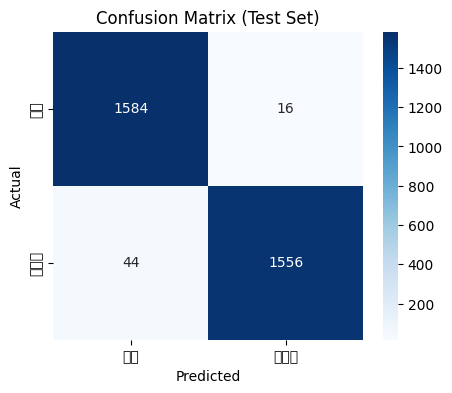

In [ ]:
evaluate_model(model1, test_loader, device=device)


[테스트셋 평가 결과]
Accuracy : 0.9853
F1-score : 0.9853


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 45433 (\N{HANGUL SYLLABLE NOG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45433 (\N{HANGUL SYLLABLE NOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48708 (\N{HANGUL

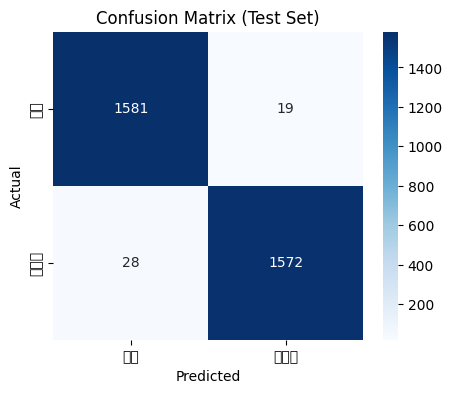

In [ ]:
evaluate_model(model2, test_loader, device=device)


[테스트셋 평가 결과]
Accuracy : 0.9853
F1-score : 0.9853


/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 45433 (\N{HANGUL SYLLABLE NOG}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45433 (\N{HANGUL SYLLABLE NOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48708 (\N{HANGUL

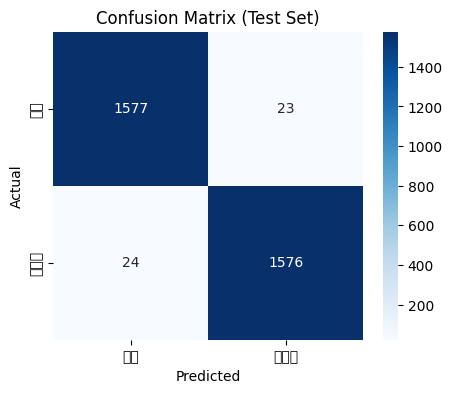

In [ ]:
evaluate_model(model3, test_loader, device=device)

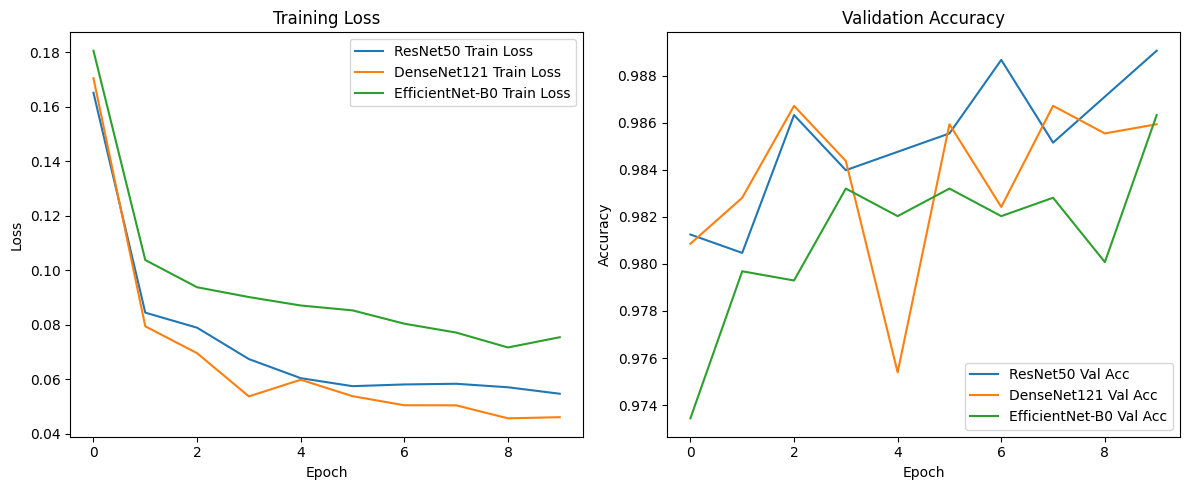

In [ ]:
plot_logs_multiple_models({
    'ResNet50': (train_loss_log1, val_acc_log1),
    'DenseNet121': (train_loss_log2, val_acc_log2),
    'EfficientNet-B0': (train_loss_log3, val_acc_log3)
})

In [ ]:
# 저장하기
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pickle
import torch

# ResNet50
torch.save(model1.state_dict(), "/content/drive/MyDrive/GradCAM/resnet50_model.pt")
# DenseNet121
torch.save(model2.state_dict(), "/content/drive/MyDrive/GradCAM/densenet121_model.pt")
# EfficientNet-B0
torch.save(model3.state_dict(), "/content/drive/MyDrive/GradCAM/efficientnet_b0_model.pt")

with open("/content/drive/MyDrive/GradCAM/resnet50_logs.pkl", "wb") as f:
    pickle.dump({'train_loss': train_loss_log1, 'val_acc': val_acc_log1}, f)
with open("/content/drive/MyDrive/GradCAM/densenet121_logs.pkl", "wb") as f:
    pickle.dump({'train_loss': train_loss_log2, 'val_acc': val_acc_log2}, f)
with open("/content/drive/MyDrive/GradCAM/efficientnet_b0_logs.pkl", "wb") as f:
    pickle.dump({'train_loss': train_loss_log3, 'val_acc': val_acc_log3}, f)


In [ ]:
import pickle
import torch
import torchvision
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 2

# 1) 모델 아키텍처 재생성 (학습 때와 동일한 옵션)
model1 = models.resnet50(num_classes=NUM_CLASSES).to(device)
model2 = models.densenet121(num_classes=NUM_CLASSES).to(device)
model3 = models.efficientnet_b0(num_classes=NUM_CLASSES).to(device)

# 2) state_dict 로드 (각자 매칭되는 파일로)
state = torch.load("/content/drive/MyDrive/GradCAM/resnet50_model.pt", map_location=device)
model1.load_state_dict(state)

state = torch.load("/content/drive/MyDrive/GradCAM/densenet121_model.pt", map_location=device)
model2.load_state_dict(state)

state = torch.load("/content/drive/MyDrive/GradCAM/efficientnet_b0_model.pt", map_location=device)
model3.load_state_dict(state)

# 3) 평가 모드
model1.eval(); model2.eval(); model3.eval()

# 4) 로그 불러오기 (읽기 모드 + pickle.load)
with open("/content/drive/MyDrive/GradCAM/resnet50_logs.pkl", "rb") as f:
    logs1 = pickle.load(f)
train_loss_log1 = logs1['train_loss']; val_acc_log1 = logs1['val_acc']

with open("/content/drive/MyDrive/GradCAM/densenet121_logs.pkl", "rb") as f:
    logs2 = pickle.load(f)
train_loss_log2 = logs2['train_loss']; val_acc_log2 = logs2['val_acc']

with open("/content/drive/MyDrive/GradCAM/efficientnet_b0_logs.pkl", "rb") as f:
    logs3 = pickle.load(f)
train_loss_log3 = logs3['train_loss']; val_acc_log3 = logs3['val_acc']

In [ ]:
import torch
import pickle
from torchvision import models
import torch.nn as nn

# 모델 정의 함수 (이진 분류용)
def build_resnet50(num_classes=2):
    model = models.resnet50(pretrained=False)
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)
    return model

def build_densenet121(num_classes=2):
    model = models.densenet121(pretrained=False)
    in_features = model.classifier.in_features
    model.classifier = nn.Linear(in_features, num_classes)
    return model

def build_efficientnet_b0(num_classes=2):
    model = models.efficientnet_b0(pretrained=False)
    in_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(in_features, num_classes)
    return model

# 모델 로드
model1 = build_resnet50()
model1.load_state_dict(torch.load("/content/drive/MyDrive/GradCAM/resnet50_model.pt"))

model2 = build_densenet121()
model2.load_state_dict(torch.load("/content/drive/MyDrive/GradCAM/densenet121_model.pt"))

model3 = build_efficientnet_b0()
model3.load_state_dict(torch.load("/content/drive/MyDrive/GradCAM/efficientnet_b0_model.pt"))

# 학습 로그 불러오기
with open("/content/drive/MyDrive/GradCAM/resnet50_logs.pkl", "rb") as f:
    logs1 = pickle.load(f)
    train_loss_log1 = logs1['train_loss']
    val_acc_log1 = logs1['val_acc']

with open("/content/drive/MyDrive/GradCAM/densenet121_logs.pkl", "rb") as f:
    logs2 = pickle.load(f)
    train_loss_log2 = logs2['train_loss']
    val_acc_log2 = logs2['val_acc']

with open("/content/drive/MyDrive/GradCAM/efficientnet_b0_logs.pkl", "rb") as f:
    logs3 = pickle.load(f)
    train_loss_log3 = logs3['train_loss']
    val_acc_log3 = logs3['val_acc']

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
import matplotlib.pyplot as plt

def plot_logs(train_losses, val_accuracies):
    plt.figure(figsize=(10, 4))

    # (1) Train Loss
    plt.subplot(1, 2, 1)
    epochs = range(1, len(train_losses)+1)
    plt.plot(epochs, train_losses, marker='o', color='blue')
    plt.title("Train Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.text(epochs[-1], train_losses[-1], f"{train_losses[-1]:.4f}")

    # (2) Validation Accuracy
    plt.subplot(1, 2, 2)
    epochs = range(1, len(val_accuracies)+1)
    plt.plot(epochs, val_accuracies, marker='o', color='green')
    plt.title("Validation Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.text(epochs[-1], val_accuracies[-1], f"{val_accuracies[-1]:.4f}")

    plt.tight_layout()
    plt.show()

In [ ]:
# ResNet50: 마지막 블록(layer4)만 fine-tuning
for param in model1.layer4.parameters():
    param.requires_grad = True

# DenseNet121: 마지막 dense block만 fine-tuning
for param in model2.features.denseblock4.parameters():
    param.requires_grad = True

# EfficientNet-B0: 마지막 블록(features[7])만 fine-tuning
for param in model3.features[7].parameters():
    param.requires_grad = True

In [ ]:
target_layer1 = model1.layer4[-1]
target_layer2 = model2.features.denseblock4
target_layer3 = model3.features[-1]

In [ ]:
def gradcam_visualize(model, image, target_layer, save_path=None, class_idx=None):
    model.eval()

    input_tensor = image.unsqueeze(0).to(device)
    image_orig = image.clone().detach().cpu()

    activations = {}
    gradients = {}

    def forward_hook(module, input, output):
        activations['value'] = output

    def backward_hook(module, grad_in, grad_out):
        gradients['value'] = grad_out[0]

    # Hook 등록
    handle_fwd = target_layer.register_forward_hook(forward_hook)
    handle_bwd = target_layer.register_full_backward_hook(backward_hook)

    # Forward
    output = model(input_tensor)

    # Hook 확인
    if 'value' not in activations:
        print("Forward hook failed — target_layer가 맞는지 확인하세요.")
        handle_fwd.remove()
        handle_bwd.remove()
        return None

    if class_idx is None:
        class_idx = torch.argmax(output).item()

    # Backward
    model.zero_grad()
    score = output[0, class_idx]
    score.backward()

    # Hook 제거
    handle_fwd.remove()
    handle_bwd.remove()

    if 'value' not in gradients:
        print("Backward hook failed — target_layer가 맞는지 확인하세요.")
        return None

    grad = gradients['value']          # [1, C, H, W]
    act = activations['value']        # [1, C, H, W]

    weights = grad.mean(dim=(2, 3), keepdim=True)  # [1, C, 1, 1]
    cam = (weights * act).sum(dim=1).squeeze()     # [H, W]
    cam = torch.relu(cam)

    # Normalize
    cam -= cam.min()
    cam = cam / cam.max() if cam.max() > 0 else cam * 0
    cam = cam.detach().cpu().numpy()

    # Resize to original image size
    cam_resized = cv2.resize(cam, (image.shape[2], image.shape[1])).astype(np.float32)

    # Optional: save 시각화 바로 확인
    if save_path:
        overlay = save_gradcam_overlay(image_orig, cam_resized, save_path, imagenet_normalized=True)
        print(f"Grad-CAM saved to {save_path}")

    return cam_resized

In [ ]:
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD  = np.array([0.229, 0.224, 0.225])

def denormalize(img_chw):
    x = img_chw.detach().cpu().permute(1, 2, 0).numpy()  # CHW -> HWC
    x = (x * IMAGENET_STD) + IMAGENET_MEAN               # 표준화 해제
    return np.clip(x, 0, 1).astype(np.float32)

def save_gradcam_overlay(image_tensor, cam, save_path, imagenet_normalized=False):
    if imagenet_normalized:
        image_np = denormalize(image_tensor)
    else:
        image_np = image_tensor.permute(1,2,0).cpu().numpy()
        image_np = np.clip(image_np, 0, 1)
    heat = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    heat = cv2.cvtColor(heat, cv2.COLOR_BGR2RGB) / 255.0
    overlay = np.clip(0.5*image_np + 0.5*heat, 0, 1)
    plt.imsave(save_path, overlay)

In [ ]:
model1.to(device)
model2.to(device)
model3.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [ ]:
sample_image, _ = test_set[0]
sample_image = sample_image.to(device)

cam = gradcam_visualize(model1, sample_image, target_layer1)
if cam is not None:
    save_gradcam_overlay(sample_image, cam, "resnet50_sample0.png", imagenet_normalized=True)

cam = gradcam_visualize(model2, sample_image, target_layer2)
if cam is not None:
    save_gradcam_overlay(sample_image, cam, "densenet121_sample0.png", imagenet_normalized=True)

cam = gradcam_visualize(model3, sample_image, target_layer3)
if cam is not None:
    save_gradcam_overlay(sample_image, cam, "efficientnetb0_sample0.png", imagenet_normalized=True)

sys:1: UserWarning: Full backward hook is firing when gradients are computed with respect to module outputs since no inputs require gradients. See https://docs.pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook for more details.


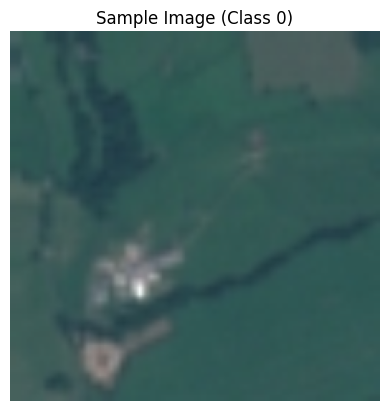

In [ ]:
sample_image, label = test_set[0]  # 이미지와 라벨 불러오기

# 텐서를 numpy 이미지로 변환
img_np = sample_image.permute(1, 2, 0).numpy()
img_np = np.clip(img_np, 0, 1).astype(np.float32)  # 안정성 확보

# 시각화
sample_image, label = test_set[0]
plt.imshow(denormalize(sample_image))
plt.axis('off')
plt.title(f"Sample Image (Class {label})")
plt.show()

In [ ]:
# 시각화 바로 확인
gradcam_visualize(model1, sample_image, target_layer1)
gradcam_visualize(model2, sample_image, target_layer2)
gradcam_visualize(model3, sample_image, target_layer3)

array([[0.2721372 , 0.2721372 , 0.2721372 , ..., 0.09283891, 0.09283891,
        0.09283891],
       [0.2721372 , 0.2721372 , 0.2721372 , ..., 0.09283891, 0.09283891,
        0.09283891],
       [0.2721372 , 0.2721372 , 0.2721372 , ..., 0.09283891, 0.09283891,
        0.09283891],
       ...,
       [0.03200943, 0.03200943, 0.03200943, ..., 0.01331363, 0.01331363,
        0.01331363],
       [0.03200943, 0.03200943, 0.03200943, ..., 0.01331363, 0.01331363,
        0.01331363],
       [0.03200943, 0.03200943, 0.03200943, ..., 0.01331363, 0.01331363,
        0.01331363]], dtype=float32)

In [ ]:
def visualize_compare_gradcam(model, image, label, true_label, target_layer, save_path=None):
    model.eval()

    # 1) 원본을 디노멀라이즈해서 표시
    img_np = denormalize(image)

    # 2) Grad-CAM (예측 클래스 / 정답 클래스)
    cam_pred = gradcam_visualize(model, image, target_layer, class_idx=None)
    cam_true = gradcam_visualize(model, image, target_layer, class_idx=label)
    if cam_pred is None or cam_true is None:
        print(f"Skipped: CAM could not be generated for label {label}")
        return

    # 시각화
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(img_np)
    axes[0].set_title(f'Original: {true_label} ({label})')
    axes[0].axis('off')

    axes[1].imshow(img_np)
    axes[1].imshow(cam_pred, cmap='jet', alpha=0.5, vmin=0, vmax=1, interpolation='bilinear')
    axes[1].set_title('Grad-CAM (Predicted)')
    axes[1].axis('off')

    axes[2].imshow(img_np)
    axes[2].imshow(cam_true, cmap='jet', alpha=0.5, vmin=0, vmax=1, interpolation='bilinear')
    axes[2].set_title('Grad-CAM (True)')
    axes[2].axis('off')

    plt.tight_layout()
    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300)
        plt.close(fig)
        print(f"Saved to {save_path}")
    else:
        plt.show()


In [ ]:
# 녹지/비녹지 레이블 설정
green_classes = ['Forest', 'HerbaceousVegetation', 'Pasture']
non_green_classes = ['Residential', 'Industrial', 'Highway']

class_to_idx = full_dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}
green_idx = [class_to_idx[c] for c in green_classes]
non_green_idx = [class_to_idx[c] for c in non_green_classes]

# Grad-CAM 비교 저장
save_dir = "gradcam_comparison"
os.makedirs(save_dir, exist_ok=True)
used_classes = set()

# 모델 목록 및 해당 target layer 지정
model_info = [
    (model1, model1.layer4[-1], "resnet50"),
    (model2, model2.features.denseblock4, "densenet121"),
    (model3, model3.features[-1], "efficientnetb0"),
]

for i, (img, label) in enumerate(full_dataset):
    if label in used_classes:
        continue

    class_name = idx_to_class[label]

    if label in green_idx:
        bin_label = 0
    elif label in non_green_idx:
        bin_label = 1
    else:
        continue  # 녹지/비녹지 아닌 경우 제외

    for model, target_layer, model_name in model_info:
        save_path = f"{save_dir}/{label}_{class_name}_{model_name}.png"

        visualize_compare_gradcam(
            model=model,
            image=img,
            label=bin_label,
            true_label=class_name,
            target_layer=target_layer,
            save_path=save_path
        )

    used_classes.add(label)

    if len(used_classes) == len(green_idx) + len(non_green_idx):
        break


Saved to gradcam_comparison/1_Forest_resnet50.png
Saved to gradcam_comparison/1_Forest_densenet121.png
Saved to gradcam_comparison/1_Forest_efficientnetb0.png
Saved to gradcam_comparison/2_HerbaceousVegetation_resnet50.png
Saved to gradcam_comparison/2_HerbaceousVegetation_densenet121.png
Saved to gradcam_comparison/2_HerbaceousVegetation_efficientnetb0.png
Saved to gradcam_comparison/3_Highway_resnet50.png
Saved to gradcam_comparison/3_Highway_densenet121.png
Saved to gradcam_comparison/3_Highway_efficientnetb0.png
Saved to gradcam_comparison/4_Industrial_resnet50.png
Saved to gradcam_comparison/4_Industrial_densenet121.png
Saved to gradcam_comparison/4_Industrial_efficientnetb0.png
Saved to gradcam_comparison/5_Pasture_resnet50.png
Saved to gradcam_comparison/5_Pasture_densenet121.png
Saved to gradcam_comparison/5_Pasture_efficientnetb0.png
Saved to gradcam_comparison/7_Residential_resnet50.png
Saved to gradcam_comparison/7_Residential_densenet121.png
Saved to gradcam_comparison/7_Re

In [ ]:
def show_gradcam_grid(image_folder, cols=3, max_images=9):
    import os
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    import numpy as np
    import math

    file_list = sorted([f for f in os.listdir(image_folder) if f.endswith('.png')])
    file_list = file_list[:max_images]

    total = len(file_list)
    rows = math.ceil(total / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

    for ax in axes:
        ax.axis('off')

    for i, file_name in enumerate(file_list):
        img_path = os.path.join(image_folder, file_name)
        img = mpimg.imread(img_path)

        # RGBA → RGB 변환
        if img.shape[-1] == 4:
            img = img[..., :3]

        axes[i].imshow(img)
        axes[i].set_title(file_name.replace(".png", ""))

    plt.tight_layout()
    plt.show()


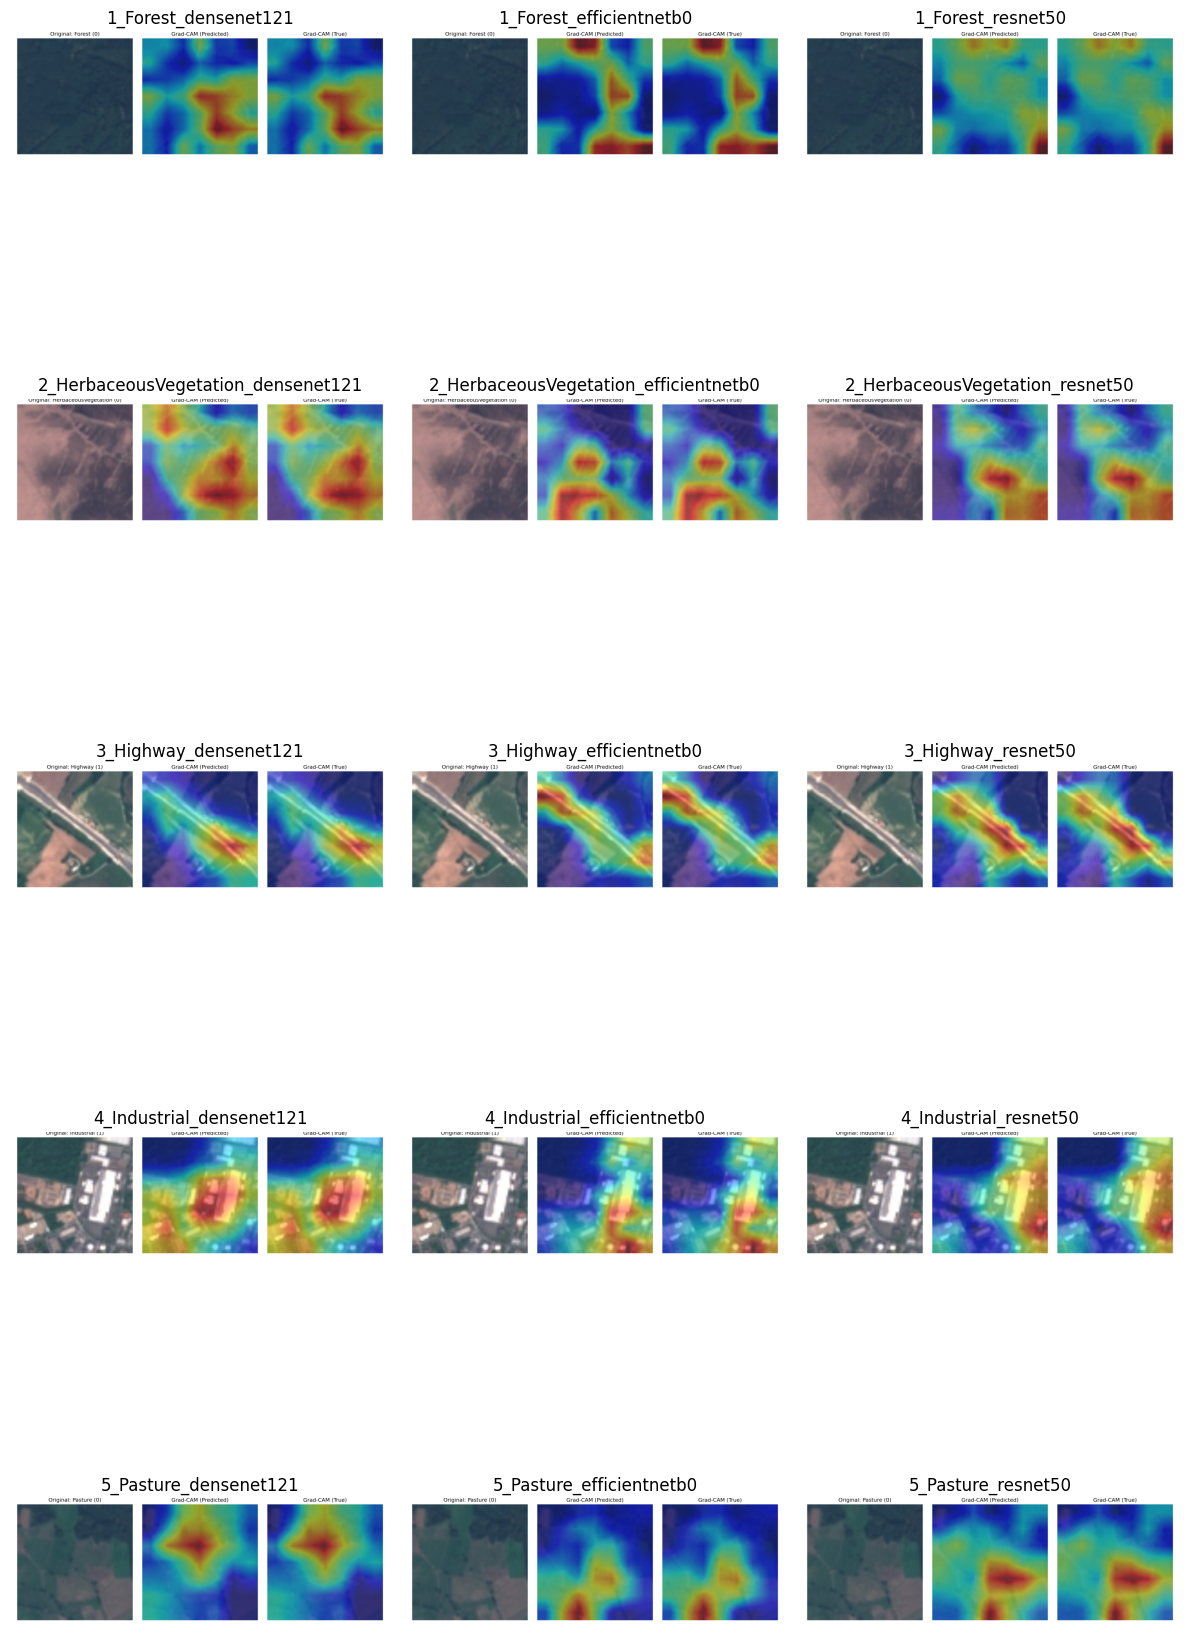

In [ ]:
show_gradcam_grid("gradcam_comparison", cols=3, max_images=15)

In [ ]:
# 저장 폴더 준비
os.makedirs("gradcam_results", exist_ok=True)

# 클래스별 샘플 1개씩 수집
class_images = {}
for img, label in test_set:
    if label not in class_images:
        class_images[label] = img
    if len(class_images) == 2:  # 클래스가 0과 1로 되어 있다면
        break

# Grad-CAM 시각화 및 저장
for cls, sample_image in class_images.items():
    cam = gradcam_visualize(model1, sample_image, target_layer1)
    if cam is None:
        print(f"Grad-CAM 실패: class {cls}")
        continue

   # 원본 이미지 복원 (denormalize 사용)
    save_gradcam_overlay(
        sample_image,
        cam,
        f"gradcam_results/class_{cls}.png",
        imagenet_normalized=True
    )

In [ ]:
def visualize_gradcam_per_class(
    model, dataset, target_layer, idx_to_class, save_dir, device,
    num_classes = 10
):
    import os
    os.makedirs(save_dir, exist_ok=True)
    used_classes = set()

    for i, (img, label) in enumerate(dataset):
        if label in used_classes:
            continue

        class_name = idx_to_class[label]
        img_input = img.to(device)
        cam = gradcam_visualize(model, img_input, target_layer)

        if cam is not None:
            save_path = os.path.join(save_dir, f"{label}_{class_name}.png")
            save_gradcam_overlay(img_input, cam, save_path, imagenet_normalized=True)
            print(f"Saved: {save_path}")

        used_classes.add(label)
        if num_classes is not None and len(used_classes) >= num_classes:
            break

In [ ]:
# ResNet50
visualize_gradcam_per_class(
    model=model1,
    dataset=full_dataset,
    target_layer=model1.layer4[-1],
    idx_to_class=idx_to_class,
    save_dir="gradcam_per_class_resnet50",
    device=device
)

# DenseNet121
visualize_gradcam_per_class(
    model=model2,
    dataset=full_dataset,
    target_layer=model2.features.denseblock4,
    idx_to_class=idx_to_class,
    save_dir="gradcam_per_class_densenet121",
    device=device
)

# EfficientNet-B0
visualize_gradcam_per_class(
    model=model3,
    dataset=full_dataset,
    target_layer=model3.features[-1],
    idx_to_class=idx_to_class,
    save_dir="gradcam_per_class_efficientnetB0",
    device=device
)


Saved: gradcam_per_class_resnet50/0_AnnualCrop.png
Saved: gradcam_per_class_resnet50/1_Forest.png
Saved: gradcam_per_class_resnet50/2_HerbaceousVegetation.png
Saved: gradcam_per_class_resnet50/3_Highway.png
Saved: gradcam_per_class_resnet50/4_Industrial.png
Saved: gradcam_per_class_resnet50/5_Pasture.png
Saved: gradcam_per_class_resnet50/6_PermanentCrop.png
Saved: gradcam_per_class_resnet50/7_Residential.png
Saved: gradcam_per_class_resnet50/8_River.png
Saved: gradcam_per_class_resnet50/9_SeaLake.png
Saved: gradcam_per_class_densenet121/0_AnnualCrop.png
Saved: gradcam_per_class_densenet121/1_Forest.png
Saved: gradcam_per_class_densenet121/2_HerbaceousVegetation.png
Saved: gradcam_per_class_densenet121/3_Highway.png
Saved: gradcam_per_class_densenet121/4_Industrial.png
Saved: gradcam_per_class_densenet121/5_Pasture.png
Saved: gradcam_per_class_densenet121/6_PermanentCrop.png
Saved: gradcam_per_class_densenet121/7_Residential.png
Saved: gradcam_per_class_densenet121/8_River.png
Saved: gr

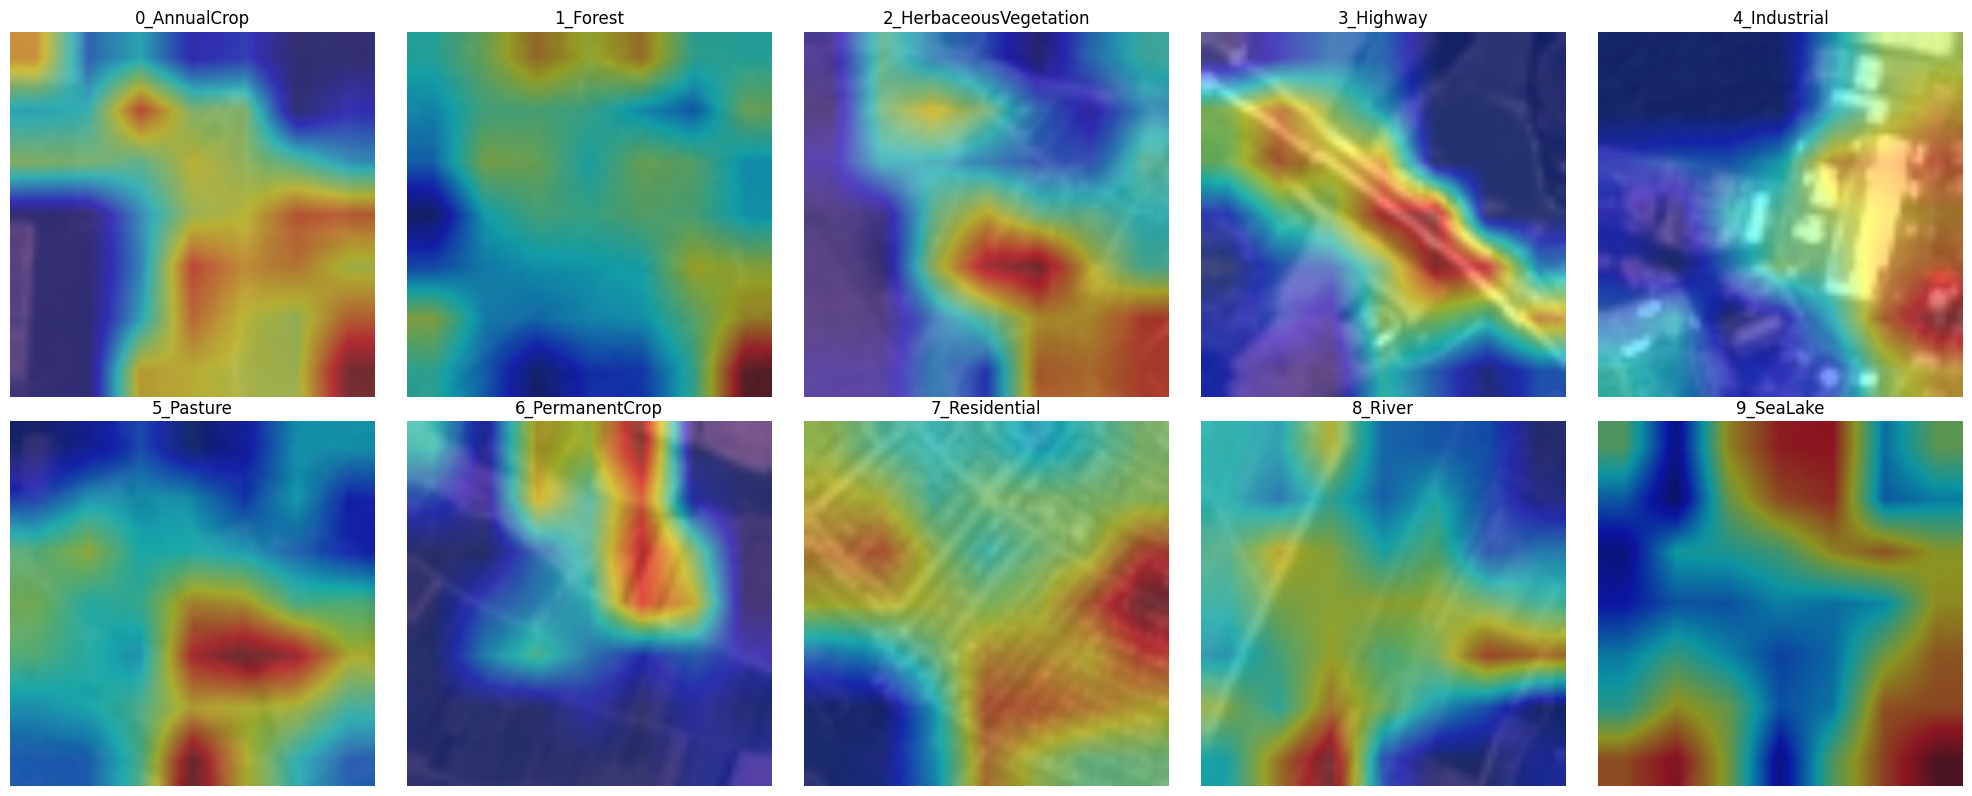

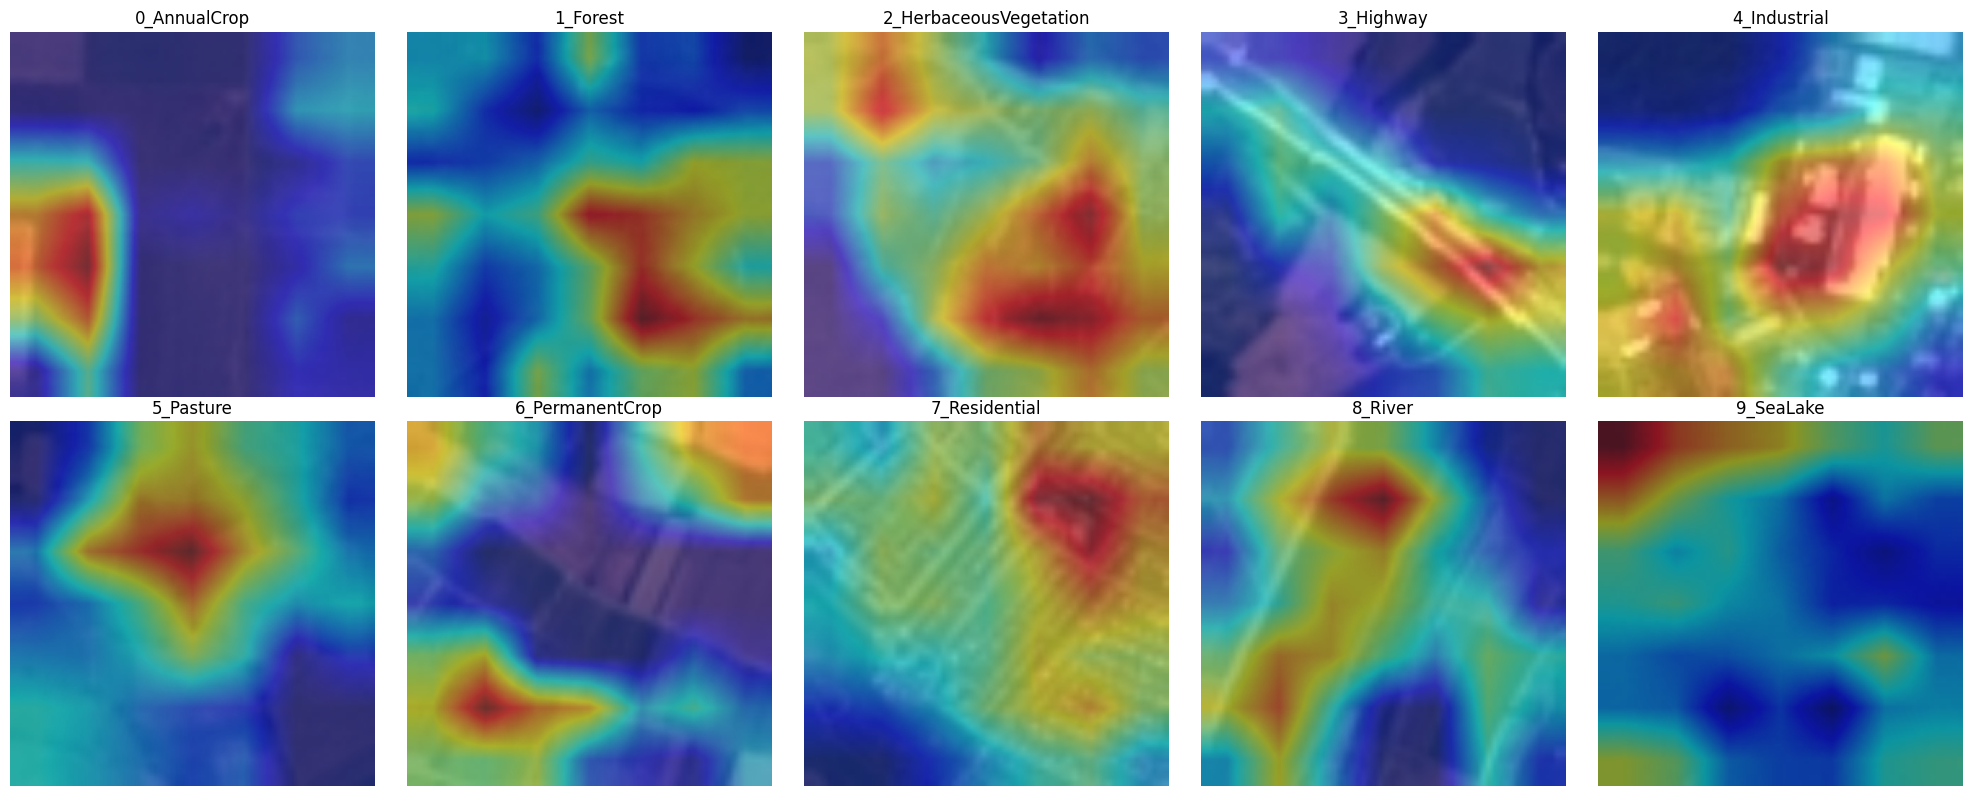

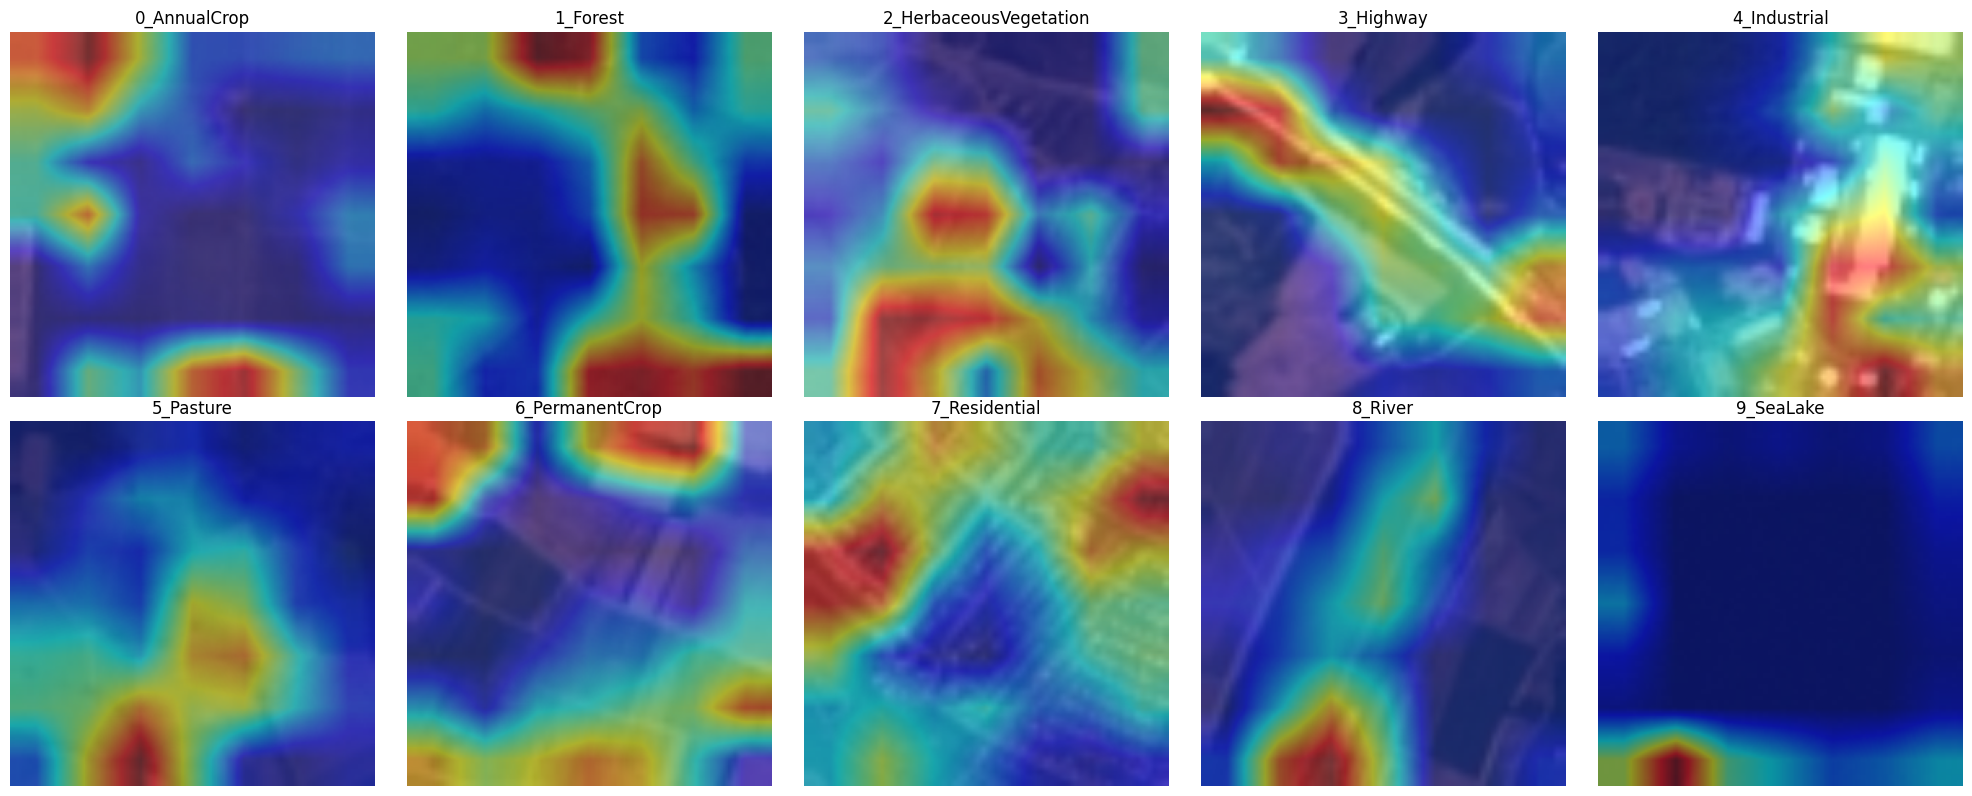

In [ ]:
show_gradcam_grid("gradcam_per_class_resnet50", cols=5, max_images=10)
show_gradcam_grid("gradcam_per_class_densenet121", cols=5, max_images=10)
show_gradcam_grid("gradcam_per_class_efficientnetB0", cols=5, max_images=10)

In [ ]:
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
IMAGENET_STD  = np.array([0.229, 0.224, 0.225], dtype=np.float32)

def perturb_image(image, mask, mode='blur', imagenet_normalized=True, device=None):
    """
    image: 정규화된 torch.Tensor (C,H,W)
    mask : np.ndarray (H,W), 0~1
    mode : 'blur' | 'black'
    """
    # 1) 디노멀라이즈 (픽셀공간)
    x = image.detach().cpu().permute(1,2,0).numpy().astype(np.float32)
    if imagenet_normalized:
        x = (x * IMAGENET_STD) + IMAGENET_MEAN
    x = np.clip(x, 0.0, 1.0)

    # 2) 대체 이미지
    if mode == 'blur':
        alt = cv2.GaussianBlur(x, (11,11), 5)
    elif mode == 'black':
        alt = np.zeros_like(x)
    else:
        raise ValueError("mode must be 'blur' or 'black'")

    # 3) 마스크 적용
    m = mask.astype(np.float32)
    if m.ndim == 2: m = m[..., None]
    pert = np.clip(x*(1-m) + alt*m, 0.0, 1.0)

    # 4) 다시 정규화 (모델 입력 분포로 복귀)
    if imagenet_normalized:
        pert = (pert - IMAGENET_MEAN) / IMAGENET_STD

    # 5) 텐서 반환
    out = torch.from_numpy(pert).permute(2,0,1).float()
    if device is not None:
        out = out.to(device, non_blocking=True)
    return out

In [ ]:
def compute_aopc(model, image, label, cam, device='cuda', steps=10,
                 order='MoRF', perturb_type='blur'):
    model.eval()

    # CAM 안전 정규화 + 리사이즈
    cam = cam.copy().astype(np.float32)
    if cam.max() > cam.min():
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
    cam = cv2.resize(cam, (image.shape[2], image.shape[1]))

    flat = cam.flatten()
    sorted_indices = np.argsort(-flat) if order == 'MoRF' else np.argsort(flat)

    # 기준점
    with torch.no_grad():
        base_score = torch.softmax(model(image.unsqueeze(0).to(device)), dim=1)[0, label].item()
    scores = [base_score]

    # 마스킹 스텝
    mask = np.zeros_like(flat, dtype=np.float32)
    pixels_per_step = len(flat) // steps

    for i in range(1, steps + 1):
        end = len(flat) if i == steps else i * pixels_per_step
        mask[sorted_indices[:end]] = 1.0
        mask_2d = mask.reshape(cam.shape)

        perturbed = perturb_image(image, mask_2d, mode=perturb_type,
                                  imagenet_normalized=True, device=device)
        with torch.no_grad():
            score = torch.softmax(model(perturbed.unsqueeze(0)), dim=1)[0, label].item()
        scores.append(score)

    # AOPC
    deltas = [scores[0] - s for s in scores[1:]]
    aopc = float(np.mean(deltas))
    return aopc, scores


In [ ]:
sample_image, sample_label = test_set[0]
sample_image = sample_image.to(device)

# ResNet50
cam = gradcam_visualize(model1, sample_image, target_layer1, class_idx=sample_label)

aopc_morf, _ = compute_aopc(model1, sample_image, sample_label, cam,
                            device=device, order='MoRF', perturb_type='blur')
aopc_lerf, _ = compute_aopc(model1, sample_image, sample_label, cam,
                            device=device, order='LeRF', perturb_type='blur')

print(f"AOPC-MoRF: {aopc_morf:.4f}")
print(f"AOPC-LeRF: {aopc_lerf:.4f}")

AOPC-MoRF: 0.3806
AOPC-LeRF: 0.1151


In [ ]:
# DenseNet121
cam = gradcam_visualize(model2, sample_image, target_layer2, class_idx=sample_label)

aopc_morf, _ = compute_aopc(model2, sample_image, sample_label, cam,
                            device=device, order='MoRF', perturb_type='blur')
aopc_lerf, _ = compute_aopc(model2, sample_image, sample_label, cam,
                            device=device, order='LeRF', perturb_type='blur')

print(f"AOPC-MoRF: {aopc_morf:.4f}")
print(f"AOPC-LeRF: {aopc_lerf:.4f}")

AOPC-MoRF: 0.5945
AOPC-LeRF: 0.1953


In [ ]:
# EfficientNetB0
cam = gradcam_visualize(model3, sample_image, target_layer3, class_idx=sample_label)

aopc_morf, _ = compute_aopc(model3, sample_image, sample_label, cam,
                            device=device, order='MoRF', perturb_type='blur')
aopc_lerf, _ = compute_aopc(model3, sample_image, sample_label, cam,
                            device=device, order='LeRF', perturb_type='blur')

print(f"AOPC-MoRF: {aopc_morf:.4f}")
print(f"AOPC-LeRF: {aopc_lerf:.4f}")

AOPC-MoRF: 0.5423
AOPC-LeRF: 0.5976


In [ ]:
from collections import defaultdict
import numpy as np
import torch

def compute_aopc_by_class(
    model,
    dataset,
    target_layer,
    idx_to_class=None,
    device='cuda',
    steps=10,
    orders=('MoRF','LeRF'),
    perturb_types=('blur',),
    samples_per_class=10,
    seed=42,
    class_basis='pred',
    correct_only=True,
    cam_fn=None,
    pos_only=True,
    cam_norm='minmax',
    return_scores=False
):
    """
    클래스별로 samples_per_class개를 계층 샘플링하여
    orders × perturb_types 조합별 AOPC를 계산.
    """
    assert cam_fn is not None, "cam_fn을 전달하세요 (예: cam_fn_gradcam)"
    model.eval()
    rng = np.random.RandomState(seed)

    if isinstance(orders, (str,)):  # normalize input
        orders = [orders]

    # --- 라벨/인덱스 수집 ---
    def _labels_and_indices(ds):
        if hasattr(ds, 'targets'):
            labels = np.array(ds.targets); idxs = np.arange(len(ds))
        elif hasattr(ds, 'dataset') and hasattr(ds.dataset, 'targets') and hasattr(ds, 'indices'):
            base = np.array(ds.dataset.targets); idxs = np.array(ds.indices); labels = base[idxs]
        else:
            labels = np.array([ds[i][1] for i in range(len(ds))]); idxs = np.arange(len(ds))
        return labels.astype(int), idxs.astype(int)

    labels_all, indices_all = _labels_and_indices(dataset)
    class_ids = np.unique(labels_all)

    if idx_to_class is None:
        idx_to_class = {int(c): f'class_{int(c)}' for c in class_ids}

    per_class_pool = {int(c): indices_all[labels_all == c] for c in class_ids}

    # 결과 컨테이너
    results = {od: {pt: defaultdict(list) for pt in perturb_types} for od in orders}

    # --- 계층 샘플링 & AOPC ---
    for c in class_ids:
        pool = per_class_pool[int(c)]
        if len(pool) == 0:
            continue
        k = min(samples_per_class, len(pool))
        chosen = rng.choice(pool, size=k, replace=False)

        for idx in chosen:
            img, label = dataset[int(idx)]
            img = img.to(device); label = int(label)

            # 예측/정답 기준 선택 및 오답 필터
            with torch.no_grad():
                pred = torch.argmax(model(img.unsqueeze(0)), 1).item()

            if correct_only and (pred != label):
                continue

            class_idx = pred if (class_basis == 'pred') else label

            # CAM 계산 (grad 필요)
            with torch.enable_grad():
                cam = cam_fn(model, img, target_layer, class_idx)  # (H,W) or tensor

            cam = torch.as_tensor(cam, dtype=torch.float32)
            if cam.ndim == 3:  # (C,H,W) 들어오면 평균
                cam = cam.mean(0)
            if pos_only:
                cam = torch.clamp(cam, min=0)
            if cam_norm == 'minmax':
                mn, mx = cam.min(), cam.max()
                cam = (cam - mn) / (mx - mn + 1e-6)

            cam_np = cam.detach().cpu().numpy()  # compute_aopc가 NumPy 예상

            # 모든 조합 실행
            for od in orders:
                for pt in perturb_types:
                    aopc, _ = compute_aopc(
                        model, img, class_idx, cam_np,
                        device=device, steps=steps,
                        order=od, perturb_type=pt
                    )
                    results[od][pt][int(c)].append(float(aopc))

    # --- 요약 출력 (per-class + Macro) ---
    for od in orders:
        for pt in perturb_types:
            print(f"[{od} | perturb={pt}]  samples_per_class={samples_per_class}, seed={seed}, "
                  f"class_basis={class_basis}, correct_only={correct_only}")
            per_class_means = []
            for c in class_ids:
                scores = results[od][pt].get(int(c), [])
                mean = float(np.mean(scores)) if len(scores) else float('nan')
                per_class_means.append(mean)
                cname = idx_to_class.get(int(c), f'class_{int(c)}')
                print(f"  {cname:>20s} ({int(c)}): {mean:.4f}  (n={len(scores)})")
            macro = float(np.nanmean(per_class_means)) if per_class_means else float('nan')
            print(f"  {'Macro Average':>20s}: {macro:.4f}\n")

    return results if return_scores else None


In [ ]:
def cam_fn_gradcam(model, img, target_layer, class_idx):
    with torch.enable_grad():
        cam = gradcam_visualize(model, img, target_layer, class_idx=class_idx)  # (H,W) or tensor
    return torch.as_tensor(cam).float()

In [ ]:
models = [
    ("ResNet50",        model1, target_layer1),
    ("DenseNet121",     model2, target_layer2),
    ("EfficientNet-B0", model3, target_layer3),
]

common = dict(
    dataset=test_set,
    idx_to_class=binary_idx_to_class,
    device=device,
    steps=10,
    orders=('MoRF','LeRF'),
    perturb_types=('blur',),
    samples_per_class=10,
    seed=42,
    return_scores=True,
    cam_fn=cam_fn_gradcam,
    class_basis='pred',
    correct_only=True,
    pos_only=True,
    cam_norm='minmax',
)

all_results = {}  # {model_name: {order: {perturb: {class_id: [scores]}}}}
for name, m, tl in models:
    print(f"\n==== {name} ====")
    res = compute_aopc_by_class(model=m, target_layer=tl, **common)
    all_results[name] = res

# 매크로 평균
for name, res in all_results.items():
    print(f"\n== Summary: {name} ==")
    for od in common['orders']:
        for pt in common['perturb_types']:
            per_class_means = []
            for cid, scores in res[od][pt].items():
                if len(scores) == 0: continue
                per_class_means.append(float(np.mean(scores)))
            if per_class_means:
                macro = float(np.mean(per_class_means))
                print(f"  [{od} | {pt}] Macro: {macro:.4f}")



==== ResNet50 ====
[MoRF | perturb=blur]  samples_per_class=10, seed=42, class_basis=pred, correct_only=True
                 Green (0): 0.2651  (n=10)
             Non-Green (1): 0.1141  (n=10)
         Macro Average: 0.1896

[LeRF | perturb=blur]  samples_per_class=10, seed=42, class_basis=pred, correct_only=True
                 Green (0): 0.1269  (n=10)
             Non-Green (1): 0.0227  (n=10)
         Macro Average: 0.0748


==== DenseNet121 ====
[MoRF | perturb=blur]  samples_per_class=10, seed=42, class_basis=pred, correct_only=True
                 Green (0): 0.3143  (n=10)
             Non-Green (1): 0.0396  (n=10)
         Macro Average: 0.1770

[LeRF | perturb=blur]  samples_per_class=10, seed=42, class_basis=pred, correct_only=True
                 Green (0): 0.1700  (n=10)
             Non-Green (1): -0.0136  (n=10)
         Macro Average: 0.0782


==== EfficientNet-B0 ====
[MoRF | perturb=blur]  samples_per_class=10, seed=42, class_basis=pred, correct_only=True
       

In [ ]:
# 계층 샘플링 기반 AOPC
def compute_avg_aopc_stratified(
    model, dataset, target_layer, device='cuda',
    steps=10, order='MoRF', perturb_type='blur',
    samples_per_class=10, seed=42, correct_only=False,
    class_basis='gt', classes=None, max_trials_per_class=5000
):
    """
    order: 'MoRF' | 'LeRF'   /  perturb_type: 'blur' | 'black'
    correct_only=True면 올바르게 분류된 샘플만 사용
    class_basis: CAM을 정답('gt') 기준으로 볼지 예측('pred') 기준으로 볼지
    classes: [0,1,2,...] 형태로 명시 가능 (None이면 dataset에서 유추)
    samples_per_class: 각 클래스에서 뽑을 샘플 수(최대)
    """
    model.eval()
    rng = np.random.RandomState(seed)

    # --- 클래스 집합 추출 ---
    if classes is None:
        # dataset[i] -> (img, label) 라고 가정
        labels_all = []
        for i in range(len(dataset)):
            _, lb = dataset[i]
            labels_all.append(int(lb))
        classes = sorted(list(set(labels_all)))
    num_classes = len(classes)

    # --- 클래스별 인덱스 풀 구성 ---
    cls_to_indices = {c: [] for c in classes}
    for i in range(len(dataset)):
        _, lb = dataset[i]
        lb = int(lb)
        if lb in cls_to_indices:
            cls_to_indices[lb].append(i)

    # --- 클래스별 샘플링 & AOPC 계산 ---
    scores = []
    used_counts = {c: 0 for c in classes}
    for c in classes:
        idx_pool = cls_to_indices[c]
        if len(idx_pool) == 0:
            print(f"[WARN] class {c}: no samples in dataset.")
            continue

        # 셔플
        idx_pool = np.array(idx_pool)
        rng.shuffle(idx_pool)

        # correct_only인 경우, 예측이 맞는 샘플만 골라서 평가
        picked = []
        trials = 0
        for i in idx_pool:
            trials += 1
            if trials > max_trials_per_class:
                break

            img, label = dataset[i]
            img = img.to(device)
            label = int(label)

            if correct_only:
                with torch.no_grad():
                    pred = torch.argmax(model(img.unsqueeze(0)), dim=1).item()
                if pred != label:
                    continue

            # CAM 대상 클래스 선택
            if class_basis == 'pred':
                with torch.no_grad():
                    class_idx = torch.argmax(model(img.unsqueeze(0)), dim=1).item()
            else:
                class_idx = label

            # Grad-CAM 생성
            cam = gradcam_visualize(model, img, target_layer, class_idx=class_idx)
            if cam is None:
                continue

            # AOPC 계산
            aopc, _ = compute_aopc(
                model, img, class_idx, cam,
                device=device, steps=steps, order=order, perturb_type=perturb_type
            )
            scores.append(float(aopc))
            picked.append(i)

            if len(picked) >= samples_per_class:
                break

        if len(picked) == 0:
            print(f"[WARN] class {c}: no valid samples evaluated "
                  f"(correct_only={correct_only}, class_basis='{class_basis}').")
        used_counts[c] = len(picked)

    n = len(scores)
    if n == 0:
        print("[WARN] No samples evaluated (all classes failed).")
        return np.nan

    mean = float(np.mean(scores))
    std  = float(np.std(scores, ddof=1)) if n > 1 else 0.0
    ci95 = 1.96 * std / np.sqrt(n) if n > 1 else 0.0

    total_target = samples_per_class * num_classes
    print(f"[{order} | perturb={perturb_type}] Stratified AOPC over {n}/{total_target} "
          f"samples: {mean:.4f}  (±{ci95:.4f} @95% CI)")
    # 각 클래스에서 실제로 몇 개가 사용됐는지도 함께 확인
    print(" per-class counts:", used_counts)
    return mean

In [ ]:
# 모델별 비교
models = [
    ("ResNet50",        model1, target_layer1),
    ("DenseNet121",     model2, target_layer2),
    ("EfficientNet-B0", model3, target_layer3),
]

common_kwargs = dict(
    dataset=test_set,
    device=device,
    steps=10,
    perturb_type='blur',
    samples_per_class=10,
    seed=42,
    correct_only=False,
    class_basis='gt',
    classes=None
)

# MoRF
mo_results = {}
for name, m, tl in models:
    mo_results[name] = compute_avg_aopc_stratified(
        model=m, target_layer=tl, order='MoRF', **common_kwargs
    )

# LeRF
le_results = {}
for name, m, tl in models:
    le_results[name] = compute_avg_aopc_stratified(
        model=m, target_layer=tl, order='LeRF', **common_kwargs
    )

print("\n[Stratified | perturb=blur] 모델별 AOPC-MoRF:")
for name in mo_results:
    print(f"{name:15s}: {mo_results[name]:.4f}")

print("\n[Stratified | perturb=blur] 모델별 AOPC-LeRF:")
for name in le_results:
    print(f"{name:15s}: {le_results[name]:.4f}")

[MoRF | perturb=blur] Stratified AOPC over 20/20 samples: 0.1896  (±0.0760 @95% CI)
 per-class counts: {0: 10, 1: 10}
[MoRF | perturb=blur] Stratified AOPC over 20/20 samples: 0.1770  (±0.0946 @95% CI)
 per-class counts: {0: 10, 1: 10}
[MoRF | perturb=blur] Stratified AOPC over 20/20 samples: 0.4502  (±0.0820 @95% CI)
 per-class counts: {0: 10, 1: 10}
[LeRF | perturb=blur] Stratified AOPC over 20/20 samples: 0.0748  (±0.0370 @95% CI)
 per-class counts: {0: 10, 1: 10}
[LeRF | perturb=blur] Stratified AOPC over 20/20 samples: 0.0782  (±0.0549 @95% CI)
 per-class counts: {0: 10, 1: 10}
[LeRF | perturb=blur] Stratified AOPC over 20/20 samples: 0.3544  (±0.0641 @95% CI)
 per-class counts: {0: 10, 1: 10}

[Stratified | perturb=blur] 모델별 AOPC-MoRF:
ResNet50       : 0.1896
DenseNet121    : 0.1770
EfficientNet-B0: 0.4502

[Stratified | perturb=blur] 모델별 AOPC-LeRF:
ResNet50       : 0.0748
DenseNet121    : 0.0782
EfficientNet-B0: 0.3544


In [ ]:
# SaCo 드롭인 코드
import math, numpy as np, torch, torch.nn.functional as F

# --- 블러(가우시안) 유틸 ---
def gaussian_kernel2d(ks=11, sigma=3.0, device='cpu', dtype=torch.float32):
    ax = torch.arange(ks, device=device, dtype=dtype) - (ks-1)/2
    xx, yy = torch.meshgrid(ax, ax, indexing='ij')
    k = torch.exp(-(xx**2 + yy**2) / (2*sigma**2))
    k = k / (k.sum() + 1e-8)
    return k

def blur_image(img, ks=11, sigma=3.0):
    # img: (C,H,W), tensor
    C, H, W = img.shape
    k = gaussian_kernel2d(ks, sigma, img.device, img.dtype)  # (K,K)
    k = k.view(1,1,ks,ks).repeat(C,1,1,1)                    # (C,1,K,K)
    pad = ks//2
    return F.conv2d(img.unsqueeze(0), k, padding=pad, groups=C).squeeze(0)

# --- 마스킹으로 교란 (해당 영역만 블러 대체) ---
def perturb_blur(img, mask01, ks=11, sigma=3.0):
    # img:(C,H,W), mask01:(1,H,W) in {0,1}
    blurred = blur_image(img, ks, sigma)
    return img * (1 - mask01) + blurred * mask01

# --- 타깃 점수(로짓) ---
@torch.no_grad()
def class_score(model, img, class_idx):
    # img:(C,H,W)
    out = model(img.unsqueeze(0))          # (1,num_classes)
    return float(out[0, int(class_idx)].detach().cpu().item())  # 로짓 권장

# --- CAM 정규화(분위수 bin용) ---
def cam_to_bins(cam, K=10, pos_only=True):
    # cam:(H,W) or (C,H,W) -> (H*W,) float in [0,1], bins: list of boolean masks
    if isinstance(cam, torch.Tensor):
        cam = cam.detach().float().cpu()
        if cam.ndim == 3: cam = cam.mean(0)
    else:
        cam = torch.from_numpy(np.asarray(cam, np.float32))
        if cam.ndim == 3: cam = cam.mean(0)
    if pos_only:
        cam = torch.clamp(cam, min=0)

    v = cam.flatten().numpy()
    # 분위수 경계 (동일 크기 bin)
    qs = np.linspace(0.0, 1.0, K+1)
    thr = np.quantile(v, qs)
    thr[-1] += 1e-6  # 상한 포함
    bins = []
    for i in range(K):
        m = (v >= thr[i]) & (v < thr[i+1])
        bins.append(m)
    return np.array(bins)   # (K, H*W), bool

# --- SaCo: 한 이미지 ---
def saco_official_for_image(
    model, img, class_idx, cam, K=10, ks=11, sigma=3.0
):
    """
    F in [-1,1]
    - cam을 K분위로 나눠 각 bin만 블러 교란 → 점수 하락량 Δ_i 측정
    - 모든 쌍(i,j)을 비교해 saliency 순서와 영향 순서가 일치하면 +1, 반대면 -1
    """
    device = img.device
    C, H, W = img.shape

    # 원본 점수
    s0 = class_score(model, img, class_idx)

    # bin 마스크 계산
    bins = cam_to_bins(cam, K=K, pos_only=True)  # (K, H*W)
    bins = torch.from_numpy(bins.astype(np.float32)).to(device)  # (K, H*W)
    bins = bins.view(K, 1, H, W)                                 # (K,1,H,W)

    # 각 bin의 영향 Δ_i 측정
    deltas = []
    for i in range(K):
        mask = bins[i]  # (1,H,W) in {0,1}
        x_pert = perturb_blur(img, mask, ks=ks, sigma=sigma)
        si = class_score(model, x_pert, class_idx)
        deltas.append(s0 - si)  # 감소량(양수일수록 영향 큼)
    deltas = torch.tensor(deltas, device=device).float()

    # 쌍대 비교: saliency 순서(높은 bin index일수록 saliency 큼)와 Δ 순서 비교
    # 여기선 bin 인덱스 자체가 saliency 순서(하위~상위)를 나타내도록 구성되어 있음.
    # (상위 bin이 더 큰 Δ를 가지면 +1, 같으면 0, 작으면 -1)
    score = 0.0
    cnt = 0
    for i in range(K):
        for j in range(i+1, K):
            # 기대: j(더 상위)가 i보다 영향이 크다 → deltas[j] > deltas[i]
            diff = deltas[j] - deltas[i]
            if diff >  1e-8: score += 1.0
            elif diff < -1e-8: score -= 1.0
            # 같으면 0 (무득점)
            cnt += 1
    if cnt == 0: return 0.0, deltas.detach().cpu().numpy()

    Fcoef = score / cnt   # [-1,1]
    return float(Fcoef), deltas.detach().cpu().numpy()

# --- 계층 샘플링 평균(SaCo) ---
def compute_avg_saco_official_stratified(
    model, dataset, target_layer, cam_fn,
    device='cuda',
    samples_per_class=10, seed=42,
    correct_only=True, class_basis='pred', classes=None,
    K=10, ks=11, sigma=3.0, max_trials_per_class=5000
):
    """
    반환: mean_F, n, ci95
    """
    np.random.seed(seed)
    torch.manual_seed(seed)
    model.eval()

    # 클래스 목록
    if classes is None:
        labels_all = [int(dataset[i][1]) for i in range(len(dataset))]
        classes = sorted(list(set(labels_all)))

    # 클래스별 인덱스
    cls_to_indices = {c: [] for c in classes}
    for i in range(len(dataset)):
        _, lb = dataset[i]
        lb = int(lb)
        if lb in cls_to_indices:
            cls_to_indices[lb].append(i)

    Fs = []
    for c in classes:
        pool = np.array(cls_to_indices[c])
        if len(pool) == 0: continue
        np.random.shuffle(pool)

        picked = 0
        trials = 0
        for idx in pool:
            trials += 1
            if trials > max_trials_per_class: break

            img, label = dataset[int(idx)]
            img = img.to(device); label = int(label)

            # 예측/정답 기준 선택
            with torch.no_grad():
                pred = torch.argmax(model(img.unsqueeze(0)), 1).item()
            if correct_only and pred != label:
                continue
            class_idx = pred if class_basis == 'pred' else label

            # CAM 생성(+ReLU 보장)
            cam = cam_fn(model, img, target_layer, class_idx)  # (H,W)
            if not isinstance(cam, torch.Tensor): cam = torch.as_tensor(cam)
            cam = torch.clamp(cam.float(), min=0)

            # 공식 SaCo
            Fcoef, _ = saco_official_for_image(
                model, img, class_idx, cam, K=K, ks=ks, sigma=sigma
            )
            Fs.append(Fcoef)
            picked += 1
            if picked >= samples_per_class: break

    n = len(Fs)
    if n == 0:
        print("[WARN] No samples evaluated.")
        return float('nan'), 0, 0.0

    mean = float(np.mean(Fs))
    std  = float(np.std(Fs, ddof=1)) if n > 1 else 0.0
    ci95 = 1.96 * std / math.sqrt(n) if n > 1 else 0.0
    return mean, n, ci95


In [ ]:
def cam_fn_gradcam(model, img, target_layer, class_idx):
    cam = gradcam_visualize(model, img, target_layer, class_idx=class_idx)  # (H,W)
    return torch.clamp(torch.as_tensor(cam).float(), min=0)

In [ ]:
models = [
    ("ResNet50",        model1, target_layer1),
    ("DenseNet121",     model2, target_layer2),
    ("EfficientNet-B0", model3, target_layer3),
]

common = dict(
    dataset=test_set, device=device,
    samples_per_class=10, seed=42,
    correct_only=True,
    class_basis='pred',
    K=10, ks=11, sigma=3.0
)

print("\n[SaCo (official) | stratified]")
for name, m, tl in models:
    meanF, n, ci = compute_avg_saco_official_stratified(
        model=m, target_layer=tl, cam_fn=cam_fn_gradcam, **common
    )
    print(f"{name:15s}: F={meanF:.3f}  (n={n}, ±{ci:.3f})")



[SaCo (official) | stratified]
ResNet50       : F=0.376  (n=20, ±0.120)
DenseNet121    : F=0.282  (n=20, ±0.137)
EfficientNet-B0: F=0.098  (n=20, ±0.144)


In [ ]:
import torch.nn.functional as F
from scipy.stats import spearmanr

def _to_cam_tensor(cam):
    # (H,W) or (C,H,W) -> (1,1,H,W) float tensor
    if not isinstance(cam, torch.Tensor):
        cam = torch.as_tensor(cam)
    cam = cam.float()
    if cam.ndim == 3:
        cam = cam.mean(0)  # (C,H,W) -> (H,W)
    if cam.ndim == 2:
        cam = cam.unsqueeze(0).unsqueeze(0)
    return cam

def _resize_like(x, H, W, mode='bilinear'):
    return F.interpolate(x, size=(H, W), mode=mode, align_corners=False)

def _topk_mask_from_cam(cam_hw, k=0.2, pos_only=True):
    # cam_hw: (H,W) float tensor -> (H,W) bool
    cam = torch.clamp(cam_hw, min=0) if pos_only else cam_hw
    v = cam.flatten()
    n = v.numel()
    if n == 0 or k <= 0:
        return torch.zeros_like(cam, dtype=torch.bool)
    kk = max(1, int(round(n * float(k))))
    vals, _ = torch.topk(v, kk, largest=True, sorted=True)
    thr = vals.min()
    return (cam >= thr)

def _safe_spearman(a, b):
    if a.size < 3 or np.nanstd(a) == 0 or np.nanstd(b) == 0:
        return 0.0
    rho, _ = spearmanr(a, b)
    return 0.0 if np.isnan(rho) else float(rho)

def saco_spearman_inputscale(
    model, img, target_layer, class_idx, cam_fn,
    scales=(2, 4), norm='rank', topk=None,
    pos_only=True, align_sign=True, resize_mode='bilinear'
):
    """
    입력을 1/s로 축소(s in scales)해 CAM을 다시 구하고,
    원본 CAM과 Spearman 상관을 계산하여 평균 반환.
    align_sign=True면 |rho| 사용.
    """
    device = img.device
    model.eval()

    # 원본 CAM
    with torch.enable_grad():
        cam0 = cam_fn(model, img, target_layer, class_idx)  # (H,W) or tensor
    cam0 = _to_cam_tensor(cam0).to(device)
    if pos_only: cam0 = torch.clamp(cam0, min=0)
    _, _, H, W = cam0.shape
    cam0_hw = cam0[0,0]

    mask_hw = (_topk_mask_from_cam(cam0_hw, k=topk, pos_only=pos_only)
               if topk is not None else torch.ones_like(cam0_hw, dtype=torch.bool))

    rhos = []
    for s in scales:
        img_s = F.interpolate(img.unsqueeze(0), scale_factor=1.0/float(s),
                              mode='bilinear', align_corners=False)[0]
        with torch.enable_grad():
            cam_s = cam_fn(model, img_s, target_layer, class_idx)
        cam_s = _to_cam_tensor(cam_s).to(device)
        if pos_only: cam_s = torch.clamp(cam_s, min=0)
        cam_s_resized = _resize_like(cam_s, H, W, mode=resize_mode)[0,0]

        a = cam0_hw[mask_hw].flatten().detach().cpu().numpy()
        b = cam_s_resized[mask_hw].flatten().detach().cpu().numpy()
        if a.size < 3: continue

        rho = _safe_spearman(a, b)
        if align_sign:
            rho = max(abs(rho), abs(_safe_spearman(a, -b)))
        rhos.append(rho)
    return float(np.mean(rhos)) if rhos else float('nan')

def saco_iou_inputscale(
    model, img, target_layer, class_idx, cam_fn,
    scales=(2, 4), k=0.2, pos_only=True, resize_mode='bilinear'
):
    """
    입력을 1/s로 축소하여 얻은 CAM을 top-k 마스크로 이진화하고,
    원본 CAM의 top-k 마스크와 IoU를 계산해 평균 반환.
    """
    device = img.device
    model.eval()

    with torch.enable_grad():
        cam0 = cam_fn(model, img, target_layer, class_idx)
    cam0 = _to_cam_tensor(cam0).to(device)
    if pos_only: cam0 = torch.clamp(cam0, min=0)
    _, _, H, W = cam0.shape
    cam0_hw = cam0[0,0]
    m0 = _topk_mask_from_cam(cam0_hw, k=k, pos_only=pos_only)

    ious = []
    for s in scales:
        img_s = F.interpolate(img.unsqueeze(0), scale_factor=1.0/float(s),
                              mode='bilinear', align_corners=False)[0]
        with torch.enable_grad():
            cam_s = cam_fn(model, img_s, target_layer, class_idx)
        cam_s = _to_cam_tensor(cam_s).to(device)
        if pos_only: cam_s = torch.clamp(cam_s, min=0)
        cam_s_resized = _resize_like(cam_s, H, W, mode=resize_mode)[0,0]

        ms = _topk_mask_from_cam(cam_s_resized, k=k, pos_only=pos_only)
        inter = (m0 & ms).sum().item()
        union = (m0 | ms).sum().item()
        iou = (inter / union) if union > 0 else 0.0
        ious.append(float(iou))

    return float(np.mean(ious)) if ious else float('nan')

In [ ]:
# ---------- ① per-image 메트릭 수집 ----------
def collect_metrics_per_image(
    model, dataset, target_layer, cam_fn,
    device='cuda',
    samples_per_class=10, seed=42,
    correct_only=True, class_basis='pred', classes=None,
    # AOPC 설정
    steps=10, perturb_type='blur',
    # SaCo(공식) 설정
    K=10, ks=11, sigma=3.0,
    # SC(스케일 일관성) 설정
    sc_scales=(2,4), sc_topk=None, sc_iou_k=0.2
):
    """
    반환: dict of np.array (동일 길이, per-image)
      - 'aopc_morf', 'aopc_lerf', 'saco_F', 'sc_spear', 'sc_iou', 'label'
    """
    rng = np.random.RandomState(seed)
    model.eval()

    # 클래스 목록
    if classes is None:
        labels_all = [int(dataset[i][1]) for i in range(len(dataset))]
        classes = sorted(list(set(labels_all)))

    # 클래스별 인덱스
    cls_to_indices = {c: [] for c in classes}
    for i in range(len(dataset)):
        _, lb = dataset[i]
        lb = int(lb)
        if lb in cls_to_indices:
            cls_to_indices[lb].append(i)

    rec = {'aopc_morf':[], 'aopc_lerf':[], 'saco_F':[], 'sc_spear':[], 'sc_iou':[], 'label':[]}

    for c in classes:
        pool = np.array(cls_to_indices[c])
        if len(pool)==0: continue
        rng.shuffle(pool)

        picked = 0
        for idx in pool:
            img, label = dataset[int(idx)]
            img = img.to(device); label = int(label)

            # 원본 예측
            with torch.no_grad():
                pred = torch.argmax(model(img.unsqueeze(0)), 1).item()
            if correct_only and pred != label:
                continue
            class_idx = pred if class_basis=='pred' else label

            # CAM (양의 기여 보장)
            cam_raw = cam_fn(model, img, target_layer, class_idx)   # (H,W) np or tensor
            cam_t   = torch.clamp(torch.as_tensor(cam_raw).float(), min=0)  # Tensor for SaCo/SC
            cam_np  = cam_t.detach().cpu().numpy()

           # --- AOPC (MoRF/LeRF, blur) : NumPy CAM 사용 ---
            a_morf, _ = compute_aopc(
                model, img, class_idx, cam_np,
                device=device, steps=steps, order='MoRF', perturb_type=perturb_type
            )
            a_lerf, _ = compute_aopc(
                model, img, class_idx, cam_np,
                device=device, steps=steps, order='LeRF', perturb_type=perturb_type
            )

            # --- SaCo(공식) : Tensor CAM 사용 ---
            Fcoef, _ = saco_official_for_image(
                model, img, class_idx, cam_t, K=K, ks=ks, sigma=sigma
            )

            # --- SC(스케일 일관성) : cam_fn 내부에서 다시 CAM 계산하므로 그대로 ---
            sc_spear = saco_spearman_inputscale(
                model, img, target_layer, class_idx, cam_fn,
                scales=sc_scales, norm='rank', topk=sc_topk, pos_only=True, align_sign=True
            )
            sc_iou = saco_iou_inputscale(
                model, img, target_layer, class_idx, cam_fn,
                scales=sc_scales, k=sc_iou_k, pos_only=True
            )

            rec['aopc_morf'].append(float(a_morf))
            rec['aopc_lerf'].append(float(a_lerf))
            rec['saco_F'].append(float(Fcoef))
            rec['sc_spear'].append(float(sc_spear))
            rec['sc_iou'].append(float(sc_iou))
            rec['label'].append(label)

            picked += 1
            if picked >= samples_per_class: break

    # 리스트 -> numpy
    for k in rec: rec[k] = np.asarray(rec[k], dtype=np.float32)
    return rec

# ---------- ② 스피어만 상관 출력 ----------
def print_spearman(name, x, y):
    # NaN 제거
    m = ~np.isnan(x) & ~np.isnan(y)
    if m.sum() < 3:
        print(f"{name}: insufficient pairs ({m.sum()})"); return
    rho, p = spearmanr(x[m], y[m])
    print(f"{name:30s}: rho={rho:+.3f}  (n={m.sum()}, p={p:.3g})")

def compare_correlations_for_model(
    model, dataset, target_layer, cam_fn, **collect_kwargs
):
    metrics = collect_metrics_per_image(model, dataset, target_layer, cam_fn, **collect_kwargs)
    print_spearman("AOPC-MoRF  vs SaCo(official)F", metrics['aopc_morf'], metrics['saco_F'])
    print_spearman("AOPC-LeRF  vs SaCo(official)F", metrics['aopc_lerf'], metrics['saco_F'])
    print_spearman("SC-Spearman vs SaCo(official)F", metrics['sc_spear'], metrics['saco_F'])
    print_spearman("SC-IoU     vs SaCo(official)F", metrics['sc_iou'],   metrics['saco_F'])
    print_spearman("AOPC-MoRF  vs SC-Spearman    ", metrics['aopc_morf'], metrics['sc_spear'])
    print_spearman("AOPC-MoRF  vs SC-IoU        ", metrics['aopc_morf'], metrics['sc_iou'])
    print_spearman("AOPC-LeRF  vs SC-Spearman    ", metrics['aopc_lerf'], metrics['sc_spear'])
    print_spearman("AOPC-LeRF  vs SC-IoU        ", metrics['aopc_lerf'], metrics['sc_iou'])
    return metrics

# ---------- ③ 실행 ----------
def cam_fn_gradcam(model, img, target_layer, class_idx):
    cam = gradcam_visualize(model, img, target_layer, class_idx=class_idx)
    return torch.clamp(torch.as_tensor(cam).float(), min=0)

models = [
    ("ResNet50",        model1, target_layer1),
    ("DenseNet121",     model2, target_layer2),
    ("EfficientNet-B0", model3, target_layer3),
]

collect_common = dict(
    dataset=test_set, device=device,
    samples_per_class=10, seed=42,
    correct_only=True, class_basis='pred', classes=None,
    steps=10, perturb_type='blur',
    K=10, ks=11, sigma=3.0,
    sc_scales=(2,4), sc_topk=None, sc_iou_k=0.2
)

for name, m, tl in models:
    print(f"\n=== Correlations | {name} ===")
    _ = compare_correlations_for_model(
        model=m,
        target_layer=tl,
        cam_fn=cam_fn_gradcam,
        **collect_common
    )


=== Correlations | ResNet50 ===
AOPC-MoRF  vs SaCo(official)F : rho=+0.082  (n=20, p=0.733)
AOPC-LeRF  vs SaCo(official)F : rho=+0.023  (n=20, p=0.924)
SC-Spearman vs SaCo(official)F: rho=-0.177  (n=20, p=0.454)
SC-IoU     vs SaCo(official)F : rho=-0.376  (n=20, p=0.102)
AOPC-MoRF  vs SC-Spearman     : rho=-0.078  (n=20, p=0.743)
AOPC-MoRF  vs SC-IoU          : rho=-0.423  (n=20, p=0.0633)
AOPC-LeRF  vs SC-Spearman     : rho=+0.167  (n=20, p=0.482)
AOPC-LeRF  vs SC-IoU          : rho=-0.152  (n=20, p=0.523)

=== Correlations | DenseNet121 ===
AOPC-MoRF  vs SaCo(official)F : rho=+0.543  (n=20, p=0.0133)
AOPC-LeRF  vs SaCo(official)F : rho=+0.404  (n=20, p=0.0771)
SC-Spearman vs SaCo(official)F: rho=-0.096  (n=20, p=0.687)
SC-IoU     vs SaCo(official)F : rho=-0.258  (n=20, p=0.271)
AOPC-MoRF  vs SC-Spearman     : rho=-0.376  (n=20, p=0.102)
AOPC-MoRF  vs SC-IoU          : rho=-0.152  (n=20, p=0.523)
AOPC-LeRF  vs SC-Spearman     : rho=-0.367  (n=20, p=0.112)
AOPC-LeRF  vs SC-IoU        